# XGBoost vs LightGBM

In this notebook we collect the results from all the experiments and reports the comparative difference between XGBoost and LightGBM

In [1]:
import matplotlib.pyplot as plt
import nbformat
import json
from toolz import pipe, juxt
import pandas as pd
import seaborn
from toolz import curry

from bokeh.io import show, output_notebook
from bokeh.charts import Bar
from bokeh.models.renderers import GlyphRenderer
from bokeh.models.glyphs import Rect
from bokeh.models import Range1d
from toolz import curry
from bokeh.io import export_svgs
from IPython.display import SVG, display
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

/anaconda/envs/strata/lib/python3.5/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


In [2]:
output_notebook()

Loading BokehJS ...

We are going to read the results from the following notebooks

In [3]:
notebooks = {
    'Airline':'01_airline.ipynb',
    'Airline_GPU': '01_airline_GPU.ipynb',
    'BCI': '02_BCI.ipynb',
    'BCI_GPU': '02_BCI_GPU.ipynb',
    'Football': '03_football.ipynb',
    'Football_GPU': '03_football_GPU.ipynb',
    'Planet': '04_PlanetKaggle.ipynb',
    'Plannet_GPU': '04_PlanetKaggle_GPU.ipynb',
    'Fraud': '05_FraudDetection.ipynb',
    'Fraud_GPU': '05_FraudDetection_GPU.ipynb',
    'HIGGS': '06_HIGGS.ipynb',
    'HIGGS_GPU': '06_HIGGS_GPU.ipynb'
}

In [4]:
def read_notebook(notebook_name):
    with open(notebook_name) as f:
        return nbformat.read(f, as_version=4)

In [5]:
def results_cell_from(nb):
    for cell in nb.cells:
        if cell['cell_type']=='code' and cell['source'].startswith('# Results'):
            return cell

In [6]:
def extract_text(cell):
    return cell['outputs'][0]['text']

In [7]:
@curry
def remove_line_with(match_str, json_string):
    return '\n'.join(filter(lambda x: match_str not in x, json_string.split('\n')))

In [8]:
def process_nb(notebook_name):
    return pipe(notebook_name,
                read_notebook,
                results_cell_from,
                extract_text,
                remove_line_with('total RAM usage'),
                json.loads)

Here we collect the results from all the exeperiment notebooks. The method simply searches the notebooks for a cell that starts with # Results. It then reads that cells output in as JSON.

In [9]:
results = {nb_key:process_nb(nb_name) for nb_key, nb_name in notebooks.items()}

In [10]:
results

{'Airline': {'lgbm': {'performance': {'AUC': 0.8402372555827792,
    'Accuracy': 0.7643602509172321,
    'F1': 0.7327938097266504,
    'Precision': 0.7934939262260393,
    'Recall': 0.6807205483883755},
   'test_time': 45.19994992000284,
   'train_time': 1056.2073636010027},
  'xgb_hist': {'performance': {'AUC': 0.8384000721790869,
    'Accuracy': 0.7163687932685965,
    'F1': 0.7414381273804327,
    'Precision': 0.6534895643276287,
    'Recall': 0.856740851230127},
   'test_time': 36.26451232100226,
   'train_time': 1242.098871958995}},
 'Airline_GPU': {'lgbm': {'performance': {'AUC': 0.8420633400407397,
    'Accuracy': 0.7253679574224235,
    'F1': 0.7459552507319687,
    'Precision': 0.6647341223976702,
    'Recall': 0.8497872609318392},
   'test_time': 48.380596682982286,
   'train_time': 645.403558799997},
  'xgb_hist': {'performance': {'AUC': 0.8411899192614771,
    'Accuracy': 0.7245983323747782,
    'F1': 0.745273441487613,
    'Precision': 0.6640651298572008,
    'Recall': 0.8

In [11]:
datasets = [k for k in results.keys()]
print(datasets)
algos = [a for a in results[datasets[0]].keys()]
print(algos)

['Football_GPU', 'Airline_GPU', 'Planet', 'Airline', 'HIGGS_GPU', 'HIGGS', 'BCI_GPU', 'Plannet_GPU', 'Football', 'Fraud', 'Fraud_GPU', 'BCI']
['xgb', 'lgbm', 'xgb_hist']


We wish to compare LightGBM and XGBoost both in terms of performance as well as how long they took to train.

In [12]:
def average_performance_diff(dataset):
    lgbm_series = pd.Series(dataset['lgbm']['performance'])
    try:
        perf = 100*((lgbm_series-pd.Series(dataset['xgb']['performance']))/lgbm_series).mean()
    except KeyError:
        perf = None
    return perf

In [13]:
def train_time_ratio(dataset):
    try: 
        val = dataset['xgb']['train_time']/dataset['lgbm']['train_time']
    except KeyError:
        val = None
    return val

def train_time_ratio_hist(dataset):
    try: 
        val = dataset['xgb_hist']['train_time']/dataset['lgbm']['train_time']
    except KeyError:
        val = None
    return val

def test_time_ratio(dataset):
    try: 
        val = dataset['xgb']['test_time']/dataset['lgbm']['test_time']
    except KeyError:
        val = None
    return val

In [14]:
metrics = juxt(average_performance_diff, train_time_ratio, train_time_ratio_hist, test_time_ratio)
res_per_dataset = {dataset_key:metrics(dataset) for dataset_key, dataset in results.items()}

In [15]:
results_df = pd.DataFrame(res_per_dataset, index=['Perf. Difference(%)', 
                                                  'Train Time Ratio',
                                                  'Train Time Ratio Hist',
                                                  'Test Time Ratio']).T

In [16]:
results_df

,Perf. Difference(%),Train Time Ratio,Train Time Ratio Hist,Test Time Ratio
Airline,NaN,NaN,1.175999,NaN
Airline_GPU,NaN,NaN,1.970731,NaN
BCI,6.250871,1.574867,5.722316,1.567671
BCI_GPU,14.284971,4.676180,15.437377,0.649916
Football,-0.589916,3.909239,4.250369,0.983060
Football_GPU,0.157673,7.268249,4.697221,0.223588
Fraud,-1.076624,6.581430,3.048036,1.353828
Fraud_GPU,-0.780054,19.746408,5.587415,0.922902
HIGGS,0.786893,25.106132,1.015684,0.781086
HIGGS_GPU,NaN,NaN,1.598361,NaN


In [17]:
results_gpu = results_df.ix[[idx for idx in results_df.index if idx.endswith('GPU')]]
results_cpu = results_df.ix[~results_df.index.isin(results_gpu.index)]

Plot of train time ratio for CPU experiments.

In [18]:
data = {
    'Ratio': results_cpu['Train Time Ratio'].values.tolist() + results_cpu['Train Time Ratio Hist'].values.tolist(),
    'label': results_cpu.index.values.tolist()*2,
    'group': ['xgb/lgb']*len(results_cpu.index.values) + ['xgb_hist/lgb']*len(results_cpu.index.values)
}

In [19]:
bar = Bar(data, values='Ratio', agg='mean', label='label', group='group', 
          plot_width=600, plot_height=400, bar_width=0.7, color=['#5975a4','#99ccff'], legend='top_right')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Train Time Ratio (XGBoost/LightGBM)'
bar.axis[1].axis_label_text_font_size='12pt'
bar.y_range = Range1d(0, 30)
bar.toolbar_location='above'
bar.legend[0].visible=True
show(bar)

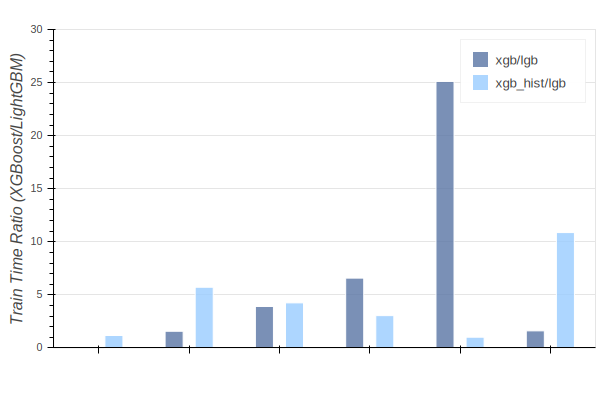

In [20]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_train_time.svg")
display(SVG('xgb_vs_lgbm_train_time.svg'))

Plot of train time ratio for GPU experiments.

In [21]:
data = {
    'Ratio': results_gpu['Train Time Ratio'].values.tolist() + results_gpu['Train Time Ratio Hist'].values.tolist(),
    'label': results_gpu.index.values.tolist()*2,
    'group': ['xgb/lgb']*len(results_gpu.index.values) + ['xgb_hist/lgb']*len(results_gpu.index.values)
}

In [22]:
bar = Bar(data, values='Ratio', agg='mean', label='label', group='group', 
          plot_width=600, plot_height=400, bar_width=0.5, color=['#ff8533','#ffd1b3'], legend='top_right')
bar.axis[0].axis_label=''
bar.y_range = Range1d(0, 30)
bar.axis[1].axis_label='Train Time Ratio (XGBoost/LightGBM)'
bar.axis[1].axis_label_text_font_size='12pt'
bar.toolbar_location='above'
bar.legend[0].visible=True
show(bar)

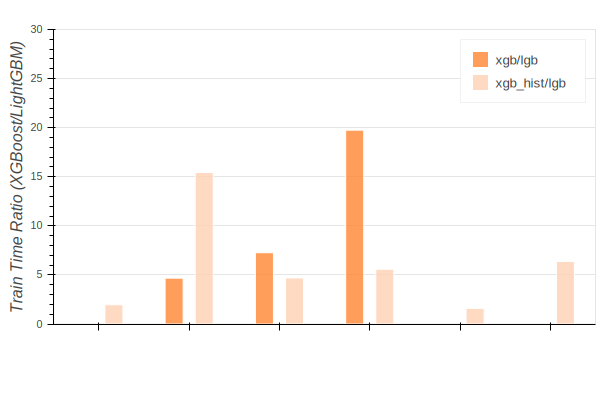

In [23]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_train_time_gpu.svg")
display(SVG('xgb_vs_lgbm_train_time_gpu.svg'))

In [24]:
data = {
    'Perf. Difference(%)': results_df['Perf. Difference(%)'].values,
    'label': results_df.index.values
}

In [25]:
bar = Bar(data, values='Perf. Difference(%)', agg='mean', label=['label'], 
          plot_width=600, plot_height=400, bar_width=0.7, color='#5975a4')
bar.axis[0].axis_label=''
bar.axis[1].axis_label='Perf. Difference(%)'
bar.toolbar_location='above'
bar.legend[0].visible=False
show(bar)

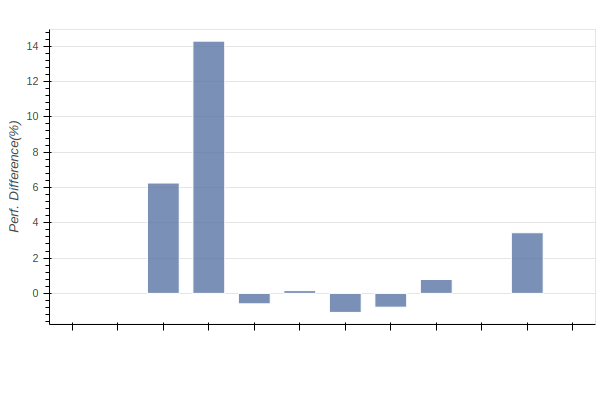

In [26]:
bar.output_backend = "svg"
export_svgs(bar, filename="xgb_vs_lgbm_performance.svg")
display(SVG('xgb_vs_lgbm_performance.svg'))

For the speed results we can see that LightGBM is on average 5 times faster than the CPU and GPU versions of XGBoost and XGBoost histogram. In regards to the performance, we can see that LightGBM is sometimes better and sometimes worse. 

Analyzing the results of XGBoost in CPU we can see that XGBoost histogram is faster than XGBoost in the Airline, Fraud and HIGGS datasets, but much slower in Planet and BCI dataset. In these two cases there is a memory overhead due to the high number of features. In the case of football dataset, the histogram implementation is slightly slower, we believe that there could be a slight principle of memory overhead.

Finally, if we look at the results of XGBoost in GPU we see that there are several values missing. This is due to an out of memory of the standard version. In our experiments we observed that XGBoost's memory consumption is around 10 times higher than LightGBM and 5 times higher than XGBoost histogram. We see that the histogram version is faster except in the BCI dataset, where there could be a memory overhead like in the CPU version. 